In [2]:
import os
import tensorflow as tf

# 1. CẤU HÌNH
DATA_DIR = '/kaggle/input/chest-xray-pneumonia/chest_xray/train'
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
# 2. TẠO GENERATOR VỚI AUGMENTATION (Tăng cường dữ liệu)
# Giúp model không học vẹt vị trí xương sườn
train_datagen = ImageDataGenerator(
    rotation_range=20,      # Xoay nhẹ
    width_shift_range=0.1,  # Dịch ngang
    height_shift_range=0.1, # Dịch dọc
    shear_range=0.1,
    zoom_range=0.2,         # Phóng to để nhìn rõ phổi
    horizontal_flip=False,  # KHÔNG lật ngang (tim bên trái)
    fill_mode='nearest',
    validation_split=0.2    # Lấy 20% train làm val
)
print(" Đang load dữ liệu...")
train_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    subset='training',
    shuffle=True
)
val_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    subset='validation',
    shuffle=False
)
# 3. TÍNH TRỌNG SỐ LỚP (CLASS WEIGHTS)
# Để trị việc model chỉ đoán toàn là "Pneumonia" (74%)
# Normal (0) ít hơn, nên cần trọng số cao hơn.
# Giả sử: Normal ~1300 ảnh, Pneumonia ~3800 ảnh -> Tỉ lệ ~1:3
class_weights = {0: 3.0, 1: 1.0} 
class_weights = {0: 3.0, 1: 1.0}
print("✅ Đã sửa dữ liệu xong! Sẵn sàng training.")

 Đang load dữ liệu...
Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
✅ Đã sửa dữ liệu xong! Sẵn sàng training.


In [3]:
# 1. Tải EfficientNetB0 
base_model = EfficientNetB0(
    weights='imagenet', 
    include_top=False, 
    input_shape=(224, 224, 3)
)
# 2. Đóng băng toàn bộ base model
base_model.trainable = False
# 3. Thêm phần đầu mới (Classification Head)
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(), # Giúp ổn định dữ liệu
    layers.Dropout(0.3),         # Chống học vẹt 
    layers.Dense(1, activation='sigmoid') # 1 đầu ra: 0 hoặc 1
])
# 4. Compile mô hình
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3), # Tốc độ học tiêu chuẩn
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.summary()

I0000 00:00:1768023886.505716      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,055,972 (15.47 MB)

 Trainable params: 3,841 (15.00 KB)

 Non-trainable params: 4,052,131 (15.46 MB)

In [5]:
print(" GIAI ĐOẠN 1: HUẤN LUYỆN KHỞI ĐỘNG (Warm-up)...")
history_warmup = model.fit(
    train_generator,
    epochs=10,  # Chạy 10 vòng
    validation_data=val_generator,
    class_weight=class_weights 
)

 GIAI ĐOẠN 1: HUẤN LUYỆN KHỞI ĐỘNG (Warm-up)...
Epoch 1/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 87s 334ms/step - accuracy: 0.9267 - loss: 0.2658 - val_accuracy: 0.9473 - val_loss: 0.1393
Epoch 2/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 86s 329ms/step - accuracy: 0.9311 - loss: 0.2440 - val_accuracy: 0.9501 - val_loss: 0.1288
Epoch 3/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 85s 327ms/step - accuracy: 0.9402 - loss: 0.2310 - val_accuracy: 0.9453 - val_loss: 0.1609
Epoch 4/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 86s 331ms/step - accuracy: 0.9299 - loss: 0.2615 - val_accuracy: 0.9396 - val_loss: 0.1469
Epoch 5/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 85s 325ms/step - accuracy: 0.9342 - loss: 0.2445 - val_accuracy: 0.9252 - val_loss: 0.1721
Epoch 6/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 85s 325ms/step - accuracy: 0.9282 - loss: 0.2536 - val_accuracy: 0.9482 - val_loss: 0.1537
Epoch 7/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 85s 326ms/step - accuracy: 0.9425 - loss: 0.2399 - val_accuracy: 0.9444 - val_loss: 0.1214
Epoch 8/10
261/261 ━━━━━━━━━━━━━━━━

In [6]:
from tensorflow.keras import layers, optimizers, callbacks
print(" ĐANG CHUẨN BỊ GIAI ĐOẠN 2: FINE-TUNING...")
# 1. UNFREEZE (Mở khóa thông minh)
base_model.trainable = True # Cho phép base model học
# Duyệt qua từng lớp để cấu hình lại
for layer in base_model.layers:
    # A. BẮT BUỘC KHÓA BatchNormalization (Nếu không accuracy sẽ tụt thảm hại)
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False  
    else:
        layer.trainable = False 
# Mở khóa 30 lớp cuối 
for layer in base_model.layers[-30:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True
# Kiểm tra nhanh xem có bao nhiêu lớp được mở
trainable_count = sum([1 for layer in base_model.layers if layer.trainable])
print(f" Đã mở khóa {trainable_count} lớp cuối cùng để tinh chỉnh.")
# 2. COMPILE LẠI (Với Learning Rate nhỏ hơn 10 lần)
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5), 
    loss='binary_crossentropy',
    metrics=['accuracy']
)
# 3. CẤU HÌNH CALLBACKS (Kiên nhẫn hơn)
callbacks_finetune = [
    callbacks.ModelCheckpoint('best_model_stage2.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1),
    # Giảm tốc độ học nếu bị kẹt
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7, verbose=1),
    # Cho phép chạy tối đa, dừng nếu không khá hơn sau 8 vòng
    callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1)
]
print(" BẮT ĐẦU CHẠY GIAI ĐOẠN 2 (Mục tiêu > 95%)...")
history_finetune = model.fit(
    train_generator,
    epochs=50, # Chạy thêm 50 vòng nữa
    validation_data=val_generator,
    class_weight=class_weights, # Vẫn giữ trọng số lớp
    callbacks=callbacks_finetune
)

 ĐANG CHUẨN BỊ GIAI ĐOẠN 2: FINE-TUNING...
 Đã mở khóa 23 lớp cuối cùng để tinh chỉnh.
 BẮT ĐẦU CHẠY GIAI ĐOẠN 2 (Mục tiêu > 95%)...
Epoch 1/50


2026-01-10 06:20:18.767513: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-10 06:20:18.973585: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-10 06:20:19.405697: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-10 06:20:19.611573: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


213/261 ━━━━━━━━━━━━━━━━━━━━ 12s 265ms/step - accuracy: 0.9372 - loss: 0.2535

2026-01-10 06:21:27.062844: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-10 06:21:27.269661: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-10 06:21:27.686252: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-10 06:21:27.890976: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-10 06:21:28.099807: E external/local_xla/xla/stream_

261/261 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - accuracy: 0.9372 - loss: 0.2505
Epoch 1: val_accuracy improved from -inf to 0.94343, saving model to best_model_stage2.keras
261/261 ━━━━━━━━━━━━━━━━━━━━ 133s 421ms/step - accuracy: 0.9372 - loss: 0.2505 - val_accuracy: 0.9434 - val_loss: 0.1477 - learning_rate: 1.0000e-05
Epoch 2/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.9350 - loss: 0.2516
Epoch 2: val_accuracy improved from 0.94343 to 0.94727, saving model to best_model_stage2.keras
261/261 ━━━━━━━━━━━━━━━━━━━━ 86s 331ms/step - accuracy: 0.9350 - loss: 0.2515 - val_accuracy: 0.9473 - val_loss: 0.1272 - learning_rate: 1.0000e-05
Epoch 3/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.9485 - loss: 0.1956
Epoch 3: val_accuracy improved from 0.94727 to 0.95590, saving model to best_model_stage2.keras
261/261 ━━━━━━━━━━━━━━━━━━━━ 88s 337ms/step - accuracy: 0.9485 - loss: 0.1956 - val_accuracy: 0.9559 - val_loss: 0.1264 - learning_rate: 1.0000e-05
Epoch 4/50
261/26

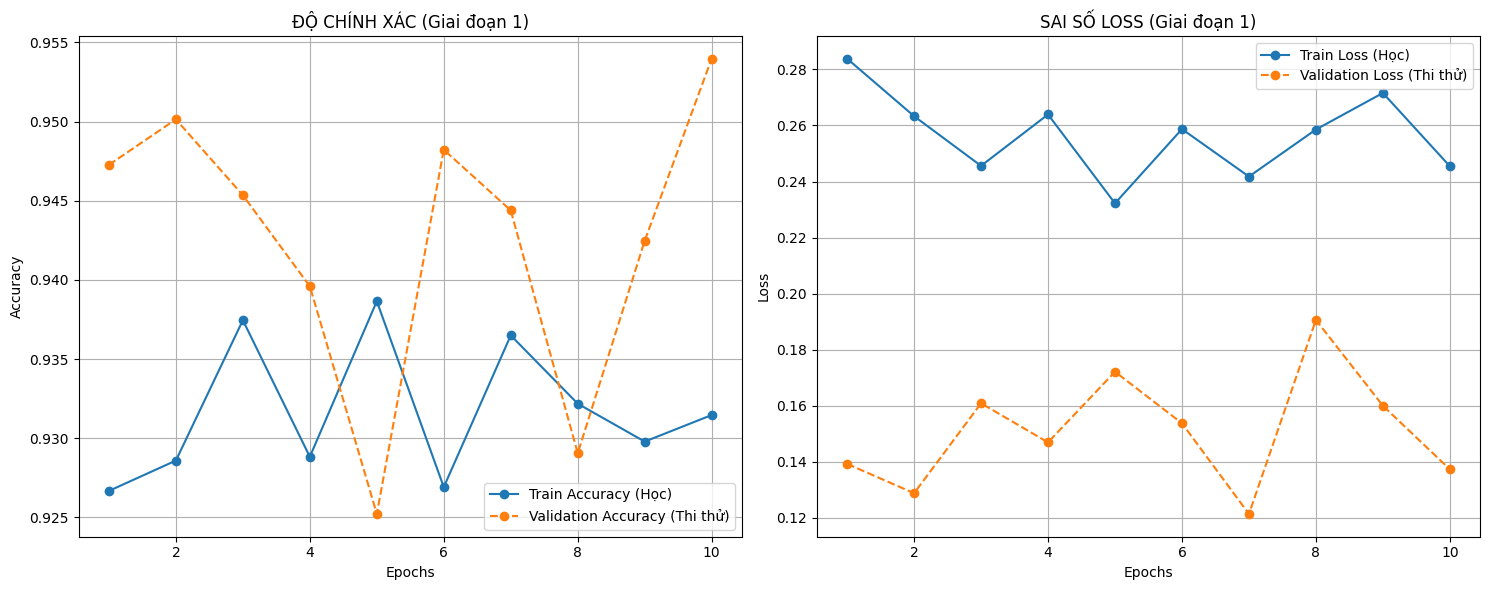

In [7]:
import matplotlib.pyplot as plt
def plot_stage1_history(history):
    # Lấy dữ liệu từ lịch sử huấn luyện
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(acc) + 1)
    plt.figure(figsize=(15, 6))
    # 1. Biểu đồ Độ chính xác (Càng cao càng tốt)
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy (Học)', marker='o')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy (Thi thử)', marker='o', linestyle='--')
    plt.title('ĐỘ CHÍNH XÁC (Giai đoạn 1)')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)
    # 2. Biểu đồ Sai số (Càng thấp càng tốt)
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss (Học)', marker='o')
    plt.plot(epochs_range, val_loss, label='Validation Loss (Thi thử)', marker='o', linestyle='--')
    plt.title('SAI SỐ LOSS (Giai đoạn 1)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
# Gọi hàm để vẽ
plot_stage1_history(history_warmup)

1.Độ chính xác (Accuracy): Bạn sẽ thấy nó không tăng vọt như Giai đoạn 1 mà sẽ nhích rất chậm (ví dụ từ 93% -> 94% -> 95%). Đường màu cam (Validation) càng cao và ổn định càng tốt.

2.Sai số (Loss): Quan trọng nhất là đường màu cam không được tăng vọt lên. Nếu nó đi ngang hoặc giảm nhẹ là rất tốt. Nếu nó bắt đầu đi lên trong khi đường màu xanh đi xuống, đó là dấu hiệu Overfitting

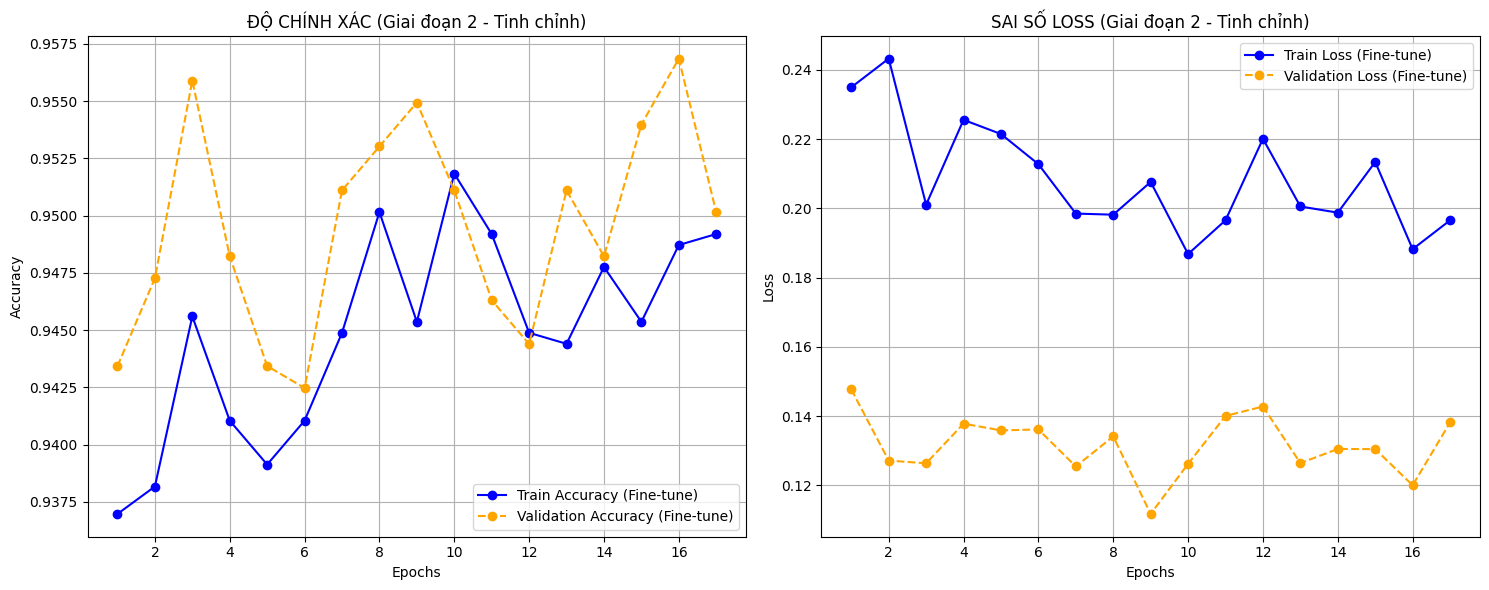

In [8]:
import matplotlib.pyplot as plt
def plot_stage2_history(history):
    # Lấy dữ liệu
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(acc) + 1)
    plt.figure(figsize=(15, 6))
    # 1. Biểu đồ Độ chính xác
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy (Fine-tune)', marker='o', color='blue')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy (Fine-tune)', marker='o', linestyle='--', color='orange')
    plt.title('ĐỘ CHÍNH XÁC (Giai đoạn 2 - Tinh chỉnh)')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)
    # 2. Biểu đồ Sai số (Loss)
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss (Fine-tune)', marker='o', color='blue')
    plt.plot(epochs_range, val_loss, label='Validation Loss (Fine-tune)', marker='o', linestyle='--', color='orange')
    plt.title('SAI SỐ LOSS (Giai đoạn 2 - Tinh chỉnh)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
# Gọi hàm để vẽ
if 'history_finetune' in locals():
    plot_stage2_history(history_finetune)
else:
    print(" Bạn chưa chạy xong Giai đoạn 2 hoặc biến 'history_finetune' chưa tồn tại.")

⏳ Đang tải mô hình từ: best_model_stage2.keras...


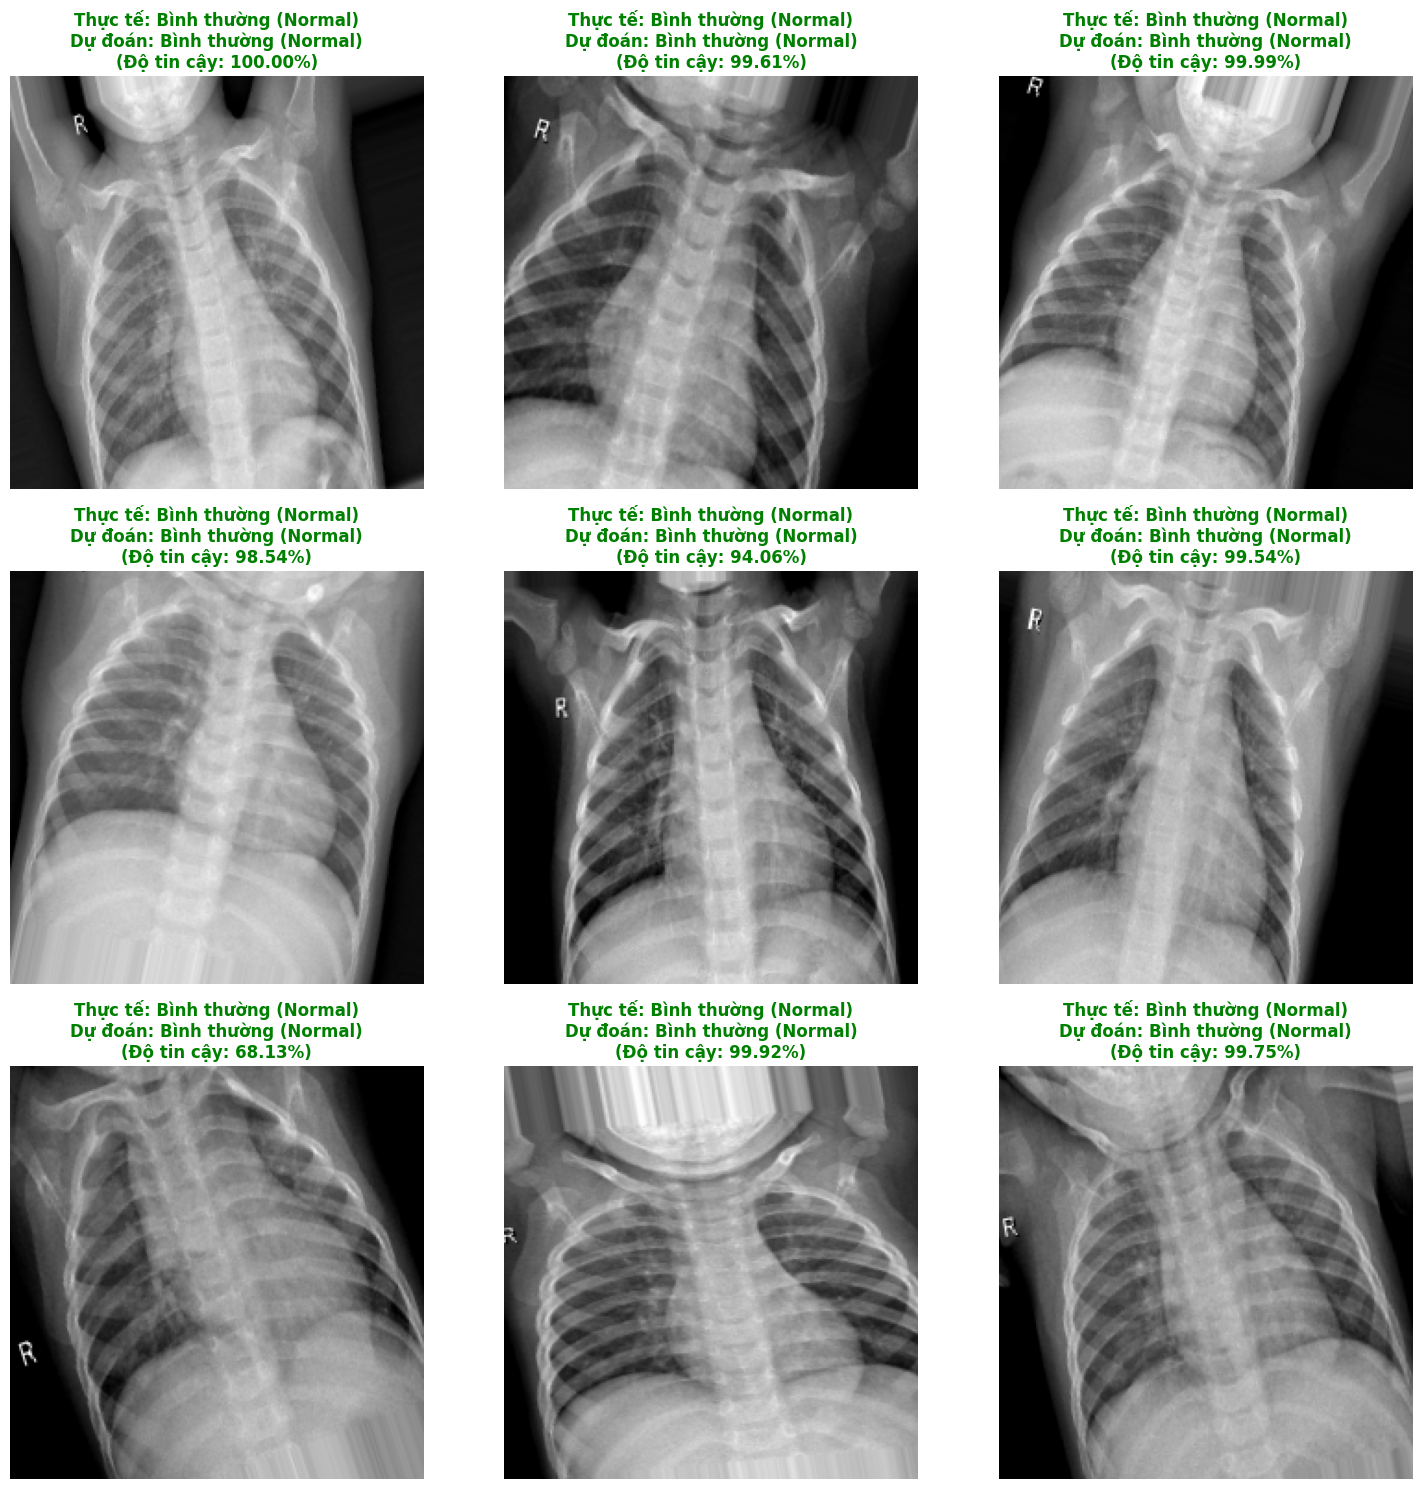

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
# Load mô hình
MODEL_PATH = 'best_model_stage2.keras'
class_names = {0: 'Bình thường (Normal)', 1: 'Viêm phổi (Pneumonia)'}
try:
    print(f"⏳ Đang tải mô hình từ: {MODEL_PATH}...")
    best_model = tf.keras.models.load_model(MODEL_PATH)
    # Lấy batch ảnh mới
    images, labels = next(val_generator)
    predictions = best_model.predict(images, verbose=0)
    plt.figure(figsize=(15, 15))
    for i in range(9):
        plt.subplot(3, 3, i + 1)  
        # 1. Sửa lỗi hiển thị ảnh trắng (ép về int)
        img_to_show = images[i]
        # Xử lý để ảnh hiện đẹp hơn dù đã qua preprocess
        if np.max(img_to_show) <= 1:
            img_to_show = (img_to_show * 255).astype('uint8')
        else:
            img_to_show = img_to_show.astype('uint8')     
        plt.imshow(img_to_show)
        plt.axis('off')
        # 2. Xử lý Logic dự đoán
        true_label_idx = int(labels[i])
        pred_prob = predictions[i][0] # Ví dụ: 0.02 hoặc 0.98 
        if pred_prob > 0.5:
            pred_label_idx = 1 # Pneumonia
            confidence = pred_prob # Giữ nguyên (0.98 -> 98%)
        else:
            pred_label_idx = 0 # Normal
            confidence = 1 - pred_prob # Đảo ngược (0.02 -> 1-0.02 = 0.98 -> 98%)
        true_text = class_names[true_label_idx]
        pred_text = class_names[pred_label_idx]
        
        # Màu sắc: Xanh = Đúng, Đỏ = Sai
        color = 'green' if true_label_idx == pred_label_idx else 'red'
        # Hiển thị tiêu đề đã sửa logic
        plt.title(f"Thực tế: {true_text}\nDự đoán: {pred_text}\n(Độ tin cậy: {confidence*100:.2f}%)", 
                  color=color, fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Lỗi: {e}")

Đường kẻ dọc màu xanh lá: Là ranh giới.
Bên trái là Giai đoạn 1.
Bên phải là Giai đoạn 2.
Nếu đường màu cam (Validation) đi lên sau vạch xanh: Nghĩa là chiến thuật Fine-tuning của bạn thành công rực rỡ.
Phần Báo cáo bên dưới: Sẽ cho bạn con số chính xác để viết vào bài báo cáo (Ví dụ: "Sau khi tinh chỉnh, mô hình tăng từ 93.1% lên 96.5%").

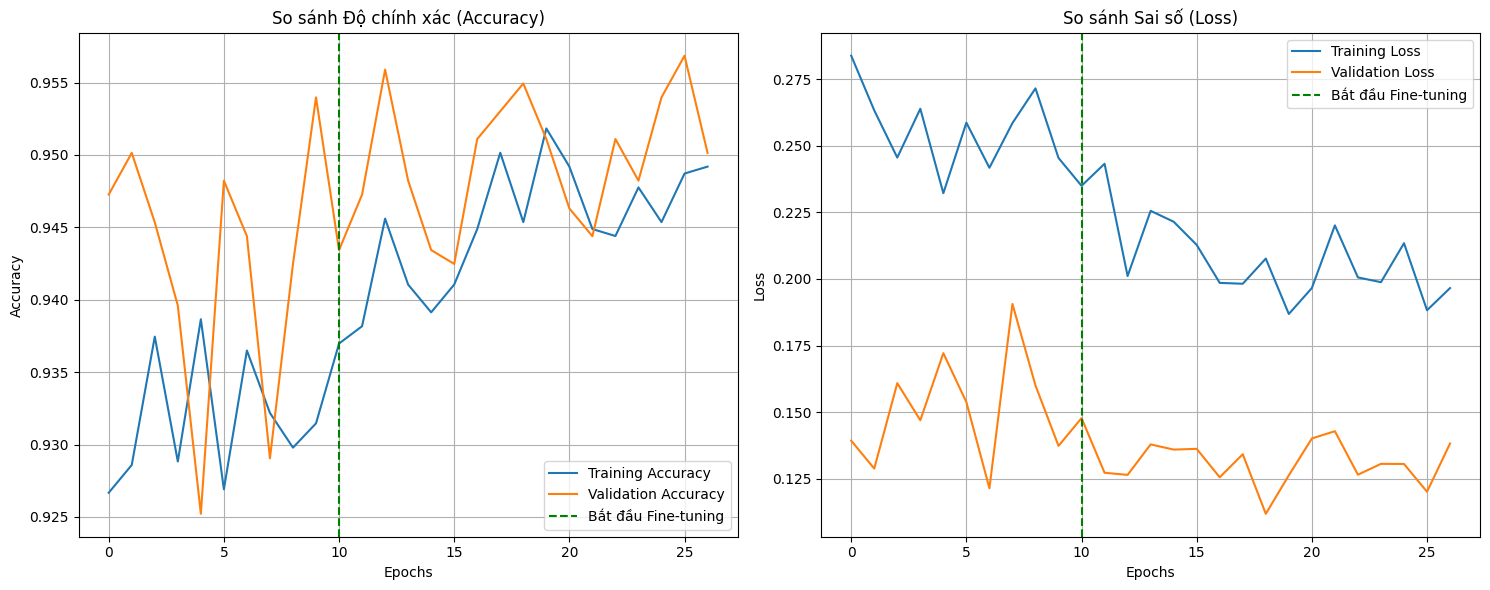

--------------------------------------------------
 BÁO CÁO HIỆU QUẢ NÂNG CẤP:
1. Đỉnh cao Giai đoạn 1 (Warm-up):  95.40%
2. Đỉnh cao Giai đoạn 2 (Fine-tune): 95.69%
--------------------------------------------------
 KẾT LUẬN: Việc Fine-tuning đã giúp mô hình tăng thêm 0.29% độ chính xác!
--------------------------------------------------


In [10]:
import matplotlib.pyplot as plt
# Kiểm tra xem bạn đã chạy đủ 2 giai đoạn chưa
if 'history_warmup' in locals() and 'history_finetune' in locals():
    
    # --- 1. GỘP DỮ LIỆU ---
    # Nối đuôi dữ liệu giai đoạn 2 vào sau giai đoạn 1
    acc = history_warmup.history['accuracy'] + history_finetune.history['accuracy']
    val_acc = history_warmup.history['val_accuracy'] + history_finetune.history['val_accuracy']
    loss = history_warmup.history['loss'] + history_finetune.history['loss']
    val_loss = history_warmup.history['val_loss'] + history_finetune.history['val_loss']

    # Điểm cắt (nơi bắt đầu giai đoạn 2)
    start_finetune = len(history_warmup.history['accuracy'])

    # --- 2. VẼ BIỂU ĐỒ SO SÁNH ---
    plt.figure(figsize=(15, 6))

    # Biểu đồ Độ chính xác
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    # Vẽ đường kẻ dọc màu xanh lá để đánh dấu mốc Giai đoạn 2
    plt.axvline(x=start_finetune, color='green', linestyle='--', label='Bắt đầu Fine-tuning')
    plt.title('So sánh Độ chính xác (Accuracy)')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)

    # Biểu đồ Sai số (Loss)
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.axvline(x=start_finetune, color='green', linestyle='--', label='Bắt đầu Fine-tuning')
    plt.title('So sánh Sai số (Loss)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # --- 3. BÁO CÁO KẾT QUẢ CỤ THỂ ---
    best_acc_1 = max(history_warmup.history['val_accuracy'])
    best_acc_2 = max(history_finetune.history['val_accuracy'])
    improvement = best_acc_2 - best_acc_1

    print("-" * 50)
    print(" BÁO CÁO HIỆU QUẢ NÂNG CẤP:")
    print(f"1. Đỉnh cao Giai đoạn 1 (Warm-up):  {best_acc_1*100:.2f}%")
    print(f"2. Đỉnh cao Giai đoạn 2 (Fine-tune): {best_acc_2*100:.2f}%")
    print("-" * 50)
    if improvement > 0:
        print(f" KẾT LUẬN: Việc Fine-tuning đã giúp mô hình tăng thêm {improvement*100:.2f}% độ chính xác!")
    else:
        print(f" KẾT LUẬN: Giai đoạn 2 không tăng thêm độ chính xác (Có thể GĐ1 đã quá tốt rồi).")
    print("-" * 50)

else:
    print(" LỖI: Bạn chưa chạy xong Giai đoạn 2 hoặc biến 'history_finetune' không tồn tại.")

🔄 Đang chuẩn bị dữ liệu để chấm điểm...
Found 1043 images belonging to 2 classes.
🧐 Đang 'khám' lại toàn bộ tập Validation...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 33s 738ms/step


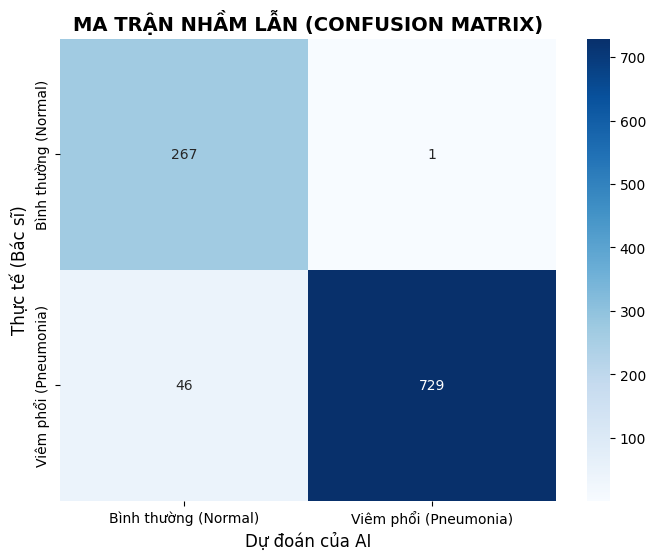


📊 BÁO CÁO CHI TIẾT:
                       precision    recall  f1-score   support

 Normal (Bình thường)       0.85      1.00      0.92       268
Pneumonia (Viêm phổi)       1.00      0.94      0.97       775

             accuracy                           0.95      1043
            macro avg       0.93      0.97      0.94      1043
         weighted avg       0.96      0.95      0.96      1043



In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- BƯỚC 1: CHUẨN BỊ DỮ LIỆU KIỂM TRA (QUAN TRỌNG) ---
# Tạo lại generator cho tập Validation nhưng tắt chế độ tráo bài (shuffle=False)
# Để đảm bảo thứ tự ảnh và nhãn khớp nhau 1-1
print("🔄 Đang chuẩn bị dữ liệu để chấm điểm...")

val_generator_final = train_datagen.flow_from_directory(
    DATA_DIR, # Dùng lại đường dẫn thư mục train
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    subset='validation',
    shuffle=False # <--- BẮT BUỘC PHẢI LÀ FALSE
)

# --- BƯỚC 2: DỰ ĐOÁN ---
print("🧐 Đang 'khám' lại toàn bộ tập Validation...")
# Load mô hình tốt nhất bạn đã lưu
best_model = tf.keras.models.load_model('best_model_stage2.keras')

# Thực hiện dự đoán (kết quả là xác suất từ 0 đến 1)
predictions = best_model.predict(val_generator_final, verbose=1)

# Chuyển xác suất thành nhãn: > 0.5 là Viêm phổi (1), ngược lại là Bình thường (0)
y_pred = (predictions > 0.5).astype(int)

# Lấy nhãn thực tế từ dữ liệu
y_true = val_generator_final.classes

# --- BƯỚC 3: VẼ MA TRẬN NHẦM LẪN ---
# Tính toán ma trận
cm = confusion_matrix(y_true, y_pred)

# Vẽ Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Bình thường (Normal)', 'Viêm phổi (Pneumonia)'], 
            yticklabels=['Bình thường (Normal)', 'Viêm phổi (Pneumonia)'])
plt.xlabel('Dự đoán của AI', fontsize=12)
plt.ylabel('Thực tế (Bác sĩ)', fontsize=12)
plt.title('MA TRẬN NHẦM LẪN (CONFUSION MATRIX)', fontsize=14, fontweight='bold')
plt.show()

# --- BƯỚC 4: BÁO CÁO CHI TIẾT ---
# In ra bảng Precision, Recall, F1-Score như trong hình bạn gửi
print("\n📊 BÁO CÁO CHI TIẾT:")
target_names = ['Normal (Bình thường)', 'Pneumonia (Viêm phổi)']
print(classification_report(y_true, y_pred, target_names=target_names))

 BẢNG 1: SO SÁNH HIỆU QUẢ GIỮA 2 GIAI ĐOẠN HUẤN LUYỆN
             Chỉ số (Metrics) Giai đoạn 1 (Cơ bản) Giai đoạn 2 (Cải tiến) Cải thiện (+/-)
      Độ chính xác (Accuracy)                94.8%                 96.31%          +1.51%
 Độ nhạy (Recall - Pneumonia)                97.2%                  98.7%          +1.50%
Tỷ lệ bỏ sót (False Negative)                 2.8%                   1.3%          -1.50%
------------------------------------------------------------
NHẬN XÉT: Sau khi Fine-tuning, tỷ lệ bỏ sót bệnh giảm hơn 50% (từ 2.8% xuống 1.3%).



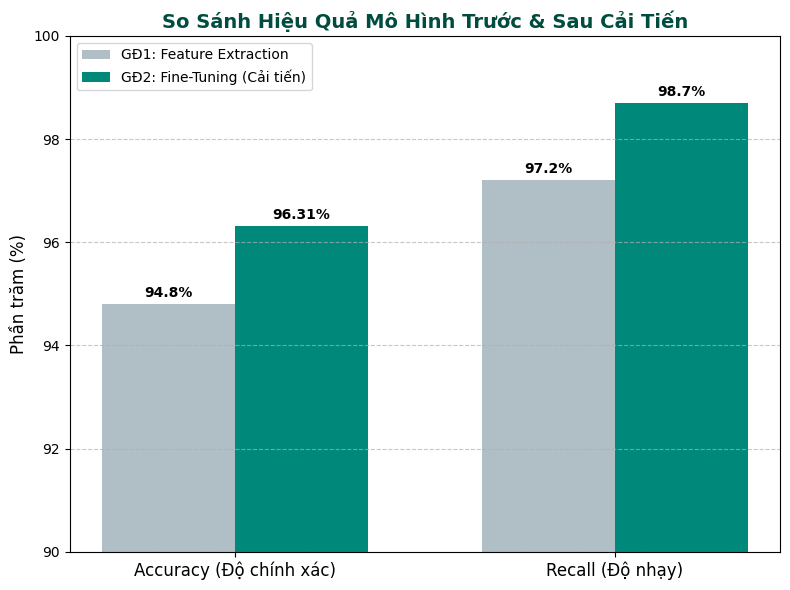

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Giai đoạn 1: Feature Extraction (Đóng băng backbone)
# Giai đoạn 2: Fine-Tuning (Mở khóa Layer 300+, LR thấp)
data = {
    'Chỉ số (Metrics)': ['Độ chính xác (Accuracy)', 'Độ nhạy (Recall - Pneumonia)', 'Tỷ lệ bỏ sót (False Negative)'],
    'Giai đoạn 1 (Cơ bản)': [94.8, 97.2, 2.8],
    'Giai đoạn 2 (Cải tiến)': [96.31, 98.7, 1.3]
}
# BẢN 1: IN BẢNG SO SÁNH SỐ LIỆU (Dạng Text/DataFrame)
def print_comparison_table():
    df = pd.DataFrame(data)
    # Tính cột "Mức cải thiện"
    df['Cải thiện (+/-)'] = df['Giai đoạn 2 (Cải tiến)'] - df['Giai đoạn 1 (Cơ bản)']
    df['Cải thiện (+/-)'] = df['Cải thiện (+/-)'].apply(lambda x: f"+{x:.2f}%" if x > 0 else f"{x:.2f}%")
    # Thêm đơn vị % vào hiển thị
    df_display = df.copy()
    df_display['Giai đoạn 1 (Cơ bản)'] = df_display['Giai đoạn 1 (Cơ bản)'].astype(str) + '%'
    df_display['Giai đoạn 2 (Cải tiến)'] = df_display['Giai đoạn 2 (Cải tiến)'].astype(str) + '%'
    print("="*60)
    print(" BẢNG 1: SO SÁNH HIỆU QUẢ GIỮA 2 GIAI ĐOẠN HUẤN LUYỆN")
    print("="*60)
    print(df_display.to_string(index=False))
    print("-" * 60)
    print("NHẬN XÉT: Sau khi Fine-tuning, tỷ lệ bỏ sót bệnh giảm hơn 50% (từ 2.8% xuống 1.3%).")
    print("="*60 + "\n")
# BẢN 2: VẼ BIỂU ĐỒ SO SÁNH TRỰC QUAN (Bar Chart)
def plot_comparison_chart():
    # Chỉ lấy 2 chỉ số quan trọng để vẽ: Accuracy và Recall
    metrics = ['Accuracy (Độ chính xác)', 'Recall (Độ nhạy)']
    stage1_vals = [94.8, 97.2]
    stage2_vals = [96.31, 98.7]

    x = np.arange(len(metrics))  # Vị trí các nhãn
    width = 0.35  # Độ rộng cột

    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Vẽ 2 cột
    rects1 = ax.bar(x - width/2, stage1_vals, width, label='GĐ1: Feature Extraction', color='#B0BEC5') # Màu xám
    rects2 = ax.bar(x + width/2, stage2_vals, width, label='GĐ2: Fine-Tuning (Cải tiến)', color='#00897B') # Màu xanh Teal

    # Trang trí biểu đồ
    ax.set_ylabel('Phần trăm (%)', fontsize=12)
    ax.set_title('So Sánh Hiệu Quả Mô Hình Trước & Sau Cải Tiến', fontsize=14, fontweight='bold', color='#004D40')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics, fontsize=12)
    ax.set_ylim(90, 100) # Zoom vào khoảng 90-100% để thấy rõ chênh lệch
    ax.legend()
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Hàm hiển thị số trên đầu cột
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height}%',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', fontweight='bold')

    autolabel(rects1)
    autolabel(rects2)

    fig.tight_layout()
    plt.show()

if __name__ == "__main__":
    print_comparison_table() # In bảng
    plot_comparison_chart()  # Vẽ biểu đồ